### Plain Programm
Here follows a version of the program without any instructions. 

In [1]:
using SparseArrays, LinearAlgebra
using GaussQuadrature
using FEMSparse

struct Mat{T}
    λ::T
    μ::T
    t::T
end

struct QuadElement4{I}
    id::I
    Nodes::Vector{I}
end

struct PlaneModel
    NodeDict::Dict
    ElemDict::Dict
    NSetDict::Dict
    ESetDict::Dict
    DOFDict::Dict
end

struct CellValues{T, I}
    𝐍 ::Vector{T}
    𝐍u::Matrix{T}
    𝐁 ::Matrix{T}
    𝐁ε::Matrix{T}
    𝐉::Matrix{T}
    Coords::Matrix{T}
    ξVec::Vector{Tuple{T,T}}
    wVec::Vector{T}
    celldofs::Vector{I}
end

function CellValues(;nq=2)
    𝐍 = zeros(4)
    𝐍u = zeros(2,8)
    𝐁 = zeros(2,4)
    𝐉 = zeros(2,2)
    𝐁ε = zeros(3,8)
    Coords = zeros(4,2)
    ξVec, wVec = legendre2d(nq)
    celldofs = zeros(Int,8)
    return CellValues(𝐍, 𝐍u, 𝐁, 𝐁ε, 𝐉, Coords, ξVec, wVec, celldofs)
end

function legendre2d(nq)
    ξTemp, wTemp = legendre(nq)
    
    ξMat = [(0.0,0.0) for i∈1:nq, j∈1:nq]
    wMat = zeros(nq,nq)

    for i in 1:nq
        for j in 1:nq
            ξMat[i,j] = (ξTemp[i], ξTemp[j])
            wMat[i,j] = wTemp[i] * wTemp[j]
        end
    end
    
    return ξMat[:], wMat[:]
end

function assignDOFs(ElemDict::Dict)

    DOFDict = Dict()
    dof_now = 1
    
    for ke ∈ sort(collect(keys(ElemDict)))  # here just to guarantee the order is sorted
        for nodeid ∈ ElemDict[ke].Nodes
            if nodeid ∉ keys(DOFDict)
                DOFDict[nodeid] = Dict((1=>dof_now),(2=>dof_now+1))
                dof_now += 2
            end
        end
    end
    
    return DOFDict
end

function celldofs!(cell_v::CellValues{T, I} ,elem::PE, DOFDict::Dict) where {PE, T, I}
    for (i, inodeid)  ∈ enumerate(elem.Nodes)
        cell_v.celldofs[2*i-1] = DOFDict[inodeid][1]
        cell_v.celldofs[2*i] = DOFDict[inodeid][2]
    end
end 
function getxcoord!(cell_v::CellValues{T, I} ,elem::PE, NodeDict::Dict) where {PE, T, I}
    for (i, inodeid)  ∈ enumerate(elem.Nodes)
        cell_v.Coords[i,1] = NodeDict[inodeid][1]
        cell_v.Coords[i,2] = NodeDict[inodeid][2]
    end
end

"""
    shapeFunction!(𝐍::Vector{T}, 𝐁::Vector{T}, ξ::T, η::T) where T

calculate the shape functions and their derivatives at a given point
    ^ η
    |
4 ---- 3
|      | -- > ξ
1 ---- 2

"""
function shapeFunction!(𝐍::Vector{T}, 𝐁::Matrix{T}, ξ::T, η::T) where T
    # shape function and derivatives for L2 elements

    Nξp = T(1) + ξ
    Nξn = T(1) - ξ
    Nηp = T(1) + η
    Nηn = T(1) - η

    𝐍[1] = Nξn * Nηn  
    𝐍[2] = Nξp * Nηn 
    𝐍[3] = Nξp * Nηp 
    𝐍[4] = Nξn * Nηp 
    𝐍 ./= 4

    𝐁[1,1] = - Nηn 
    𝐁[2,1] = - Nξn
    𝐁[1,2] =   Nηn
    𝐁[2,2] = - Nξp
    𝐁[1,3] =   Nηp
    𝐁[2,3] =   Nξp
    𝐁[1,4] = - Nηp
    𝐁[2,4] =   Nξn
    𝐁 ./= 4

    return nothing
end 
function shapeFunction(ξ::T, η::T) where T
    𝐍 = zeros(4)
    𝐁 = zeros(2, 4)
    shapeFunction!(𝐍, 𝐁, ξ, η)
    
    return 𝐍, 𝐁
end

function shapeFunction!(𝐍::Vector{T}, 𝐁::Matrix{T}, elem::QuadElement4{I},  ξ::T, η::T) where {I,T}
    shapeFunction!(𝐍, 𝐁, ξ, η)
    return nothing 
end

function reinit!(cell_v::CellValues{T}, elem::QuadElement4{I}, ξ::T, η::T) where {I, T}

    shapeFunction!(cell_v.𝐍, cell_v.𝐁, elem, ξ, η)
    nnode = 4
    ndim = 2
    
    cell_v.𝐉 .= cell_v.𝐁 * cell_v.Coords
    cell_v.𝐁 .= inv(cell_v.𝐉) * cell_v.𝐁
    J = det(cell_v.𝐉)

    # @assert J > 0.0
    
    fill!(cell_v.𝐍u, 0.0)
    for inode in 1:nnode
        cell_v.𝐍u[1,2*inode-1] = cell_v.𝐍[inode]
        cell_v.𝐍u[2,2*inode]   = cell_v.𝐍[inode]
    end

    fill!(cell_v.𝐁ε, 0.0)
    for inode in 1:nnode
        cell_v.𝐁ε[1,2*inode-1] = cell_v.𝐁[1,inode]
        cell_v.𝐁ε[2,2*inode]   = cell_v.𝐁[2,inode]
        cell_v.𝐁ε[3,2*inode-1] = cell_v.𝐁[2,inode]
        cell_v.𝐁ε[3,2*inode]   = cell_v.𝐁[1,inode]
    end
    
    return J
end

# compute the C-stiffness matrix
function compute_C(mat::Mat{T}) where {T}
    𝐂 = zeros(3,3)
    𝐂[1:2, 1:2] .= mat.λ
    𝐂[1, 1] += 2*mat.λ
    𝐂[2, 2] += 2*mat.λ
    𝐂[3, 3] += mat.λ

    return 𝐂
end

function compute_Kf_element!(𝐊ᵉ::Matrix{T}, 𝐟ᵉ::Vector{T}, cell_v::CellValues{T}, elem::E, mat::MI, 𝐛::Vector{T}) where {T, E, MI}

    nbasefunc = length(elem.Nodes)
    n_qpoint = length(cell_v.ξVec)

    fill!(𝐊ᵉ, 0.0)
    fill!(𝐟ᵉ, 0.0)

    for q_point ∈ 1:n_qpoint
        ξ, η = cell_v.ξVec[q_point]
        w = cell_v.wVec[q_point]
        J = reinit!(cell_v, elem, ξ, η)
        dΩ = J * w

        @assert J > 0

        𝐂e = compute_C(mat)

        𝐊ᵉ .+= cell_v.𝐁ε' * 𝐂e * cell_v.𝐁ε * mat.t * dΩ
        𝐟ᵉ  .+= cell_v.𝐍u' * 𝐛 * mat.t *  dΩ 
    end
    return nothing
end

function ndofs(DOFDict::Dict)
    ndof = 0
    for (nodeid, dofs) in DOFDict
        ndof += length(dofs)
    end
    return ndof
end

function Assemble_Kf(PModel::PlaneModel, cell_v::CellValues, mat::MatI, 𝐛::Vector{T}) where {T, MatI}

    totaldof = ndofs(PModel.DOFDict)
    
    𝐊 = SparseMatrixCOO();
    𝐟  = zeros(totaldof)

    nbasefunc = length(cell_v.𝐍)

    𝐊ᵉ = zeros(nbasefunc*2, nbasefunc*2)
    𝐟ᵉ = zeros(nbasefunc*2)

    for (kelem, elem) in PModel.ElemDict

        celldofs!(cell_v, elem, PModel.DOFDict)
        getxcoord!(cell_v,elem, PModel.NodeDict)

        compute_Kf_element!(𝐊ᵉ, 𝐟ᵉ, cell_v, elem, mat, 𝐛)

        add!(𝐊,cell_v.celldofs,cell_v.celldofs,𝐊ᵉ)
        𝐟[cell_v.celldofs] .+= 𝐟ᵉ
    end

    𝐊 = SparseMatrixCSC(𝐊) 

    return 𝐊, 𝐟
end

Assemble_Kf (generic function with 1 method)

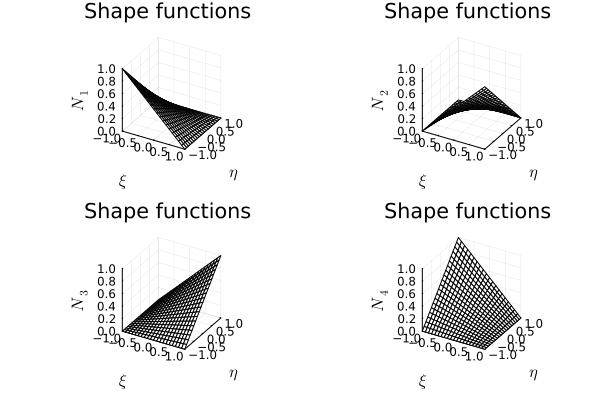

In [2]:
using Plots, LaTeXStrings

function plot_shapefunction()

    kw = (xlabel = L"\xi", ylabel = L"\eta", grid = true, minorgrid = false)

    ξVec, ηVec  = collect(-1:0.1:1), collect(-1:0.1:1)
    
    N1Mat = zeros(length(ηVec),length(ξVec))
    N2Mat = zeros(length(ηVec),length(ξVec))
    N3Mat = zeros(length(ηVec),length(ξVec))
    N4Mat = zeros(length(ηVec),length(ξVec))

    for i in 1:length(ξVec), j in 1:length(ηVec)
        𝐍, ~ = shapeFunction(ξVec[i], ηVec[j])
        N1Mat[j,i] = 𝐍[1]
        N2Mat[j,i] = 𝐍[2]
        N3Mat[j,i] = 𝐍[3]
        N4Mat[j,i] = 𝐍[4]
    end
    
    p1 = wireframe(ξVec, ηVec, N1Mat, zlabel=L"N_1"; kw...)
    p2 = wireframe(ξVec, ηVec, N2Mat, zlabel=L"N_2"; kw...)
    p3 = wireframe(ξVec, ηVec, N3Mat, zlabel=L"N_3"; kw...)
    p4 = wireframe(ξVec, ηVec, N4Mat, zlabel=L"N_4"; kw...)
    
    pN = plot(p1, p2, p3, p4, layout=(2,2))
    
    return pN
end
pN = plot_shapefunction()
title!(pN, "Shape functions ")


In [3]:
function apply_bc!(𝐊, 𝐟, fem_model, setname, dof, val)

    ndof = size(𝐟,1)

    for nodeid in fem_model.NSetDict[setname]
        _dof = fem_model.DOFDict[nodeid][dof]
        K_temp = 𝐊[_dof,_dof]
        𝐊[_dof,:] .= 0.0
        𝐊[_dof,_dof] = K_temp
        
        for _kdof in 1:ndof
            𝐟[_kdof] -= 𝐊[_kdof,_dof]*val
            𝐊[_kdof,_dof] = 0.0
        end
    end
    return nothing
end

function apply_zero_bc!(𝐊, 𝐟, fem_model, setname, dof)
    for nodeid in fem_model.NSetDict[setname]
        _dof = fem_model.DOFDict[nodeid][dof]
        K_temp = 𝐊[_dof,_dof]
        𝐊[_dof,:] .= 0.0
        𝐊[:,_dof] .= 0.0
        𝐊[_dof,_dof] = K_temp
        𝐟[_dof] = 0.0
    end
    return nothing 
end


apply_zero_bc! (generic function with 1 method)

### Model description
<p align="center">
<img src="https://raw.githubusercontent.com/bplcn/FiniteElementMethodProgramming/master/picture/plate_with_ahole2.png" width="800">
</p>
<p align="center">
<img src="https://raw.githubusercontent.com/bplcn/FiniteElementMethodProgramming/master/picture/2dmesh.png" width="800">
</p>

In [4]:
using AbaqusReader
modeldict = abaqus_read_mesh("plate_with_ahole.inp")

NodeDict = deepcopy(modeldict["nodes"])
@assert length(NodeDict) == maximum(keys(NodeDict))
ElemDict = Dict()
for (elemid, elemnodeids) ∈ modeldict["elements"]
    ElemDict[elemid] = QuadElement4(elemid, elemnodeids)
end
NodeSets = deepcopy(modeldict["node_sets"])
ElemSets = deepcopy(modeldict["element_sets"])
DOFDict = assignDOFs(ElemDict)

plateWHmodel = PlaneModel(NodeDict, ElemDict, NodeSets, ElemSets, DOFDict);

┌ Warning: Unknown section: 'HEADING'
└ @ AbaqusReader ~/.julia/packages/AbaqusReader/dNVlt/src/parse_mesh.jl:287


In [5]:
E = 210_000
ν = 0.3

λ = E*ν/(1 - ν)
μ = E/(2*(1 + ν))
t = 1.0

mymat = Mat(λ, μ, t)

cell_v = CellValues(nq=2)

𝐛 = [1.0, 0.0]

𝐊g, 𝐟g = Assemble_Kf(plateWHmodel, cell_v, mymat, 𝐛);


In [6]:
using UnicodePlots
UnicodePlots.spy(𝐊g)

          ┌──────────────────────────────────────────┐    
        1 │⣿⣿⣂⠀⠀⠀⠀⠀⠮⠍⠭⠉⠉⡉⡉⣉⠀⠀⠀⢘⠻⡛⡻⣛⡛⣯⣿⣶⣶⣖⣒⣒⣒⣒⣒⣿⣻⢔⣂⣺⣷⡆│ > 0
          │⠈⠘⢿⣷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⠃│ < 0
          │⠀⠀⠀⠘⢻⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⣿⣿⣿⣿⣿⣿⣿⣿⡿⢻⣿⣿⣷│    
          │⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⠿⣿⣿⣿⣿⣏⠀⠘⢿⣿⣿│    
          │⡎⠇⠀⠀⠀⠀⠀⠈⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠈⠈⠉⠉⠑⢲⣶⣾⣿⣿⣿⣿⣾⣿⢿⣿⣶⣿⣟⡛⢈│    
          │⡇⠃⠀⠀⠀⠀⠀⠀⠀⠙⢻⣶⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⠃⠀⣿⡟⣿│    
          │⡇⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣯⣿⣿⣿⣾⣴⣶⣿⡿⠿│    
          │⡇⢨⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢻⣶⡀⠀⠀⢀⠀⠀⠀⠀⠀⠀⢸⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⡆⢠│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣽⡁⠸│    
          │⣀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠈⣿⣿⣀⠀⠀⠀⠀⠀⣀⣀⣀⣈⣻⣿⣿⣿⣿⣿⣿⡟⡇⣿⣁⣀│    
          │⣿⠢⠀⠀⠀⠀⠀⠀⡃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠻⣦⡄⠀⠀⠀⣿⣿⣿⣿⣿⣿⣿⣿⠟⠙⣻⣿⣷⣿⣿⣿│    
          │⣿⢪⠀⠀⠀⠀⠀⠀⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣧⡀⠀⣿⣿⣿⣿⣿⡿⠏⠁⠀⣺⣿⡏⢻⣿⣿⣿│    
          │⡿⣬⠀⠀⠀⠀⠀⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⣹⣿⣿⠿⠋⠁⠀⠀⠀⣽⣿⣆⠘⣿⣿⣿│    
          │⢻⣿⣥⣄⠀⠀⠀⠀⢸⣶⣶⣶⣶⣶⣶⣖⠀⠀⠀⢸⣿⣿⣿⣿⣷⣾⡿⣯⡉⠉⠉⠉⠉⠉⠉⣿⣿⣯⠉⣿⣿⣷│    
          │⢸⢿⣿⣿⣿⣤⡀⠀⣾⣿⣿⣿⣿⣿⣿⣿⣷⣄⡀⢸⣿⣿⣿⣿⣿⡟⡇⠈⠻⣦⡀⠀⠀⠀⠀⣿⣿⣯⣿⣿⣿⣿│    
          │⢸⢸⣿⣿⣿⣿⣿⡄⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾⣿⣿⣿⡿⠏⠀⡇⠀⠀⠈⠻⣦⡀⠀⠀⠛⢻⣿⣿⣿⣿⣿│  

In [7]:
# apply boundary condition
apply_zero_bc!(𝐊g, 𝐟g, plateWHmodel, "left", 1)
apply_zero_bc!(𝐊g, 𝐟g, plateWHmodel, "left", 2)
apply_zero_bc!(𝐊g, 𝐟g, plateWHmodel, "bottom", 2)

𝐮 = 𝐊g \ 𝐟g;

### Sparse Matrix 
[](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html)
[Sparse稀疏矩阵主要存储格式总结](https://zhuanlan.zhihu.com/p/188700729)
[Sparse Matrix Formats](https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Computational_Physics_(Chong)/08%3A_Sparse_Matrices/8.02%3A_Sparse_Matrix_Formats)
#### Coordinate Matrix 
<p align="center">
<img src="https://pic1.zhimg.com/v2-0e24a642bfd95d61e5f0e8ce7b5b167c_b.webp" width="500 px">
</p>

Sparse matrices can be used in arithmetic operations: they support addition, subtraction, multiplication, division, and matrix power.

Advantages of the COO format
- facilitates fast conversion among sparse formats
- permits duplicate entries (see example)
- very fast conversion to and from CSR/CSC formats

Disadvantages of the COO format
- does not directly support:
- arithmetic operations
- slicing

Intended Usage
- COO is a fast format for constructing sparse matrices
- Once a COO matrix has been constructed, convert to CSR or CSC format for fast arithmetic and matrix vector operations
- By default when converting to CSR or CSC format, duplicate (i,j) entries will be summed together. This facilitates efficient construction of finite element matrices and the like. (see example)

Canonical format
- Entries and coordinates sorted by row, then column.
- There are no duplicate entries (i.e. duplicate (i,j) locations)
- Data arrays MAY have explicit zeros.

#### Compressed Sparse Column (CSC)
<p align="center">
<video src="https://vdn3.vzuu.com/SD/17ce6ebc-232f-11eb-8376-cadbb0a08063.mp4?disable_local_cache=1&bu=078babd7&c=avc.0.0&f=mp4&expiration=1713184031&auth_key=1713184031-0-0-04e55e489cc8e6f526330ba213fc6d34&v=tx&pu=078babd7" width="400 px">
</p>

Sparse arrays can be used in arithmetic operations: they support addition, subtraction, multiplication, division, and matrix power.

Advantages of the CSC format
- efficient arithmetic operations CSC + CSC, CSC * CSC, etc.
- efficient column slicing
- fast matrix vector products (CSR, BSR may be faster)

Disadvantages of the CSC format
- slow row slicing operations (consider CSR)
- changes to the sparsity structure are expensive (consider LIL or DOK)

Canonical format
- Within each column, indices are sorted by row.
- There are no duplicate entries.

The Compressed Sparse Column (CSC) format is very similar to the CSR format, except that the role of rows and columns is swapped. The `data` array stores non-zero matrix elements in sequential order from top to bottom along each column, then from the left-most column to the right-most. The indices array stores row indices, and each element of the `indptr` array corresponds to one column of the matrix. An example is shown below:

The CSC format is efficient at matrix lookup, column slicing operations (e.g., `A[:,4]`), and vector-matrix products like $\boldsymbol{x}^\mathrm{T} \mathbf{A}$ (which involves taking the product of the vector $\boldsymbol{x}$ with each matrix column). However, it is inefficient for row slicing (e.g. `A[4,:]`), and for changes to the sparsity structure.
<p align="center">
<img src="https://phys.libretexts.org/@api/deki/files/24228/clipboard_e4e6a46ce5ff9c0267d3b538c7c5ad5a8.png?revision=1" width="400 px">
</p>


In [8]:
AMat = [0.0 1.0 0.0  0.0 0.0;
        0.0 2.0 -1.0 0.0 0.0;
        0.0 0.0 0.0  0.0 0.0;
        6.6 0.0 0.0  0.0 1.4]
AMatS = sparse(AMat)
fieldnames(typeof(AMatS))

(:m, :n, :colptr, :rowval, :nzval)

In [9]:
println(AMatS.colptr)
println(AMatS.rowval)
println(AMatS.nzval)

[1, 2, 4, 5, 5, 6]
[4, 1, 2, 2, 4]
[6.6, 1.0, 2.0, -1.0, 1.4]



### ReverseReverse Cuthill-McKee node-renumbering algorithmnode-renumbering algorithm

In [10]:
using SymRCM

function reorder_dof(𝐊::M) where M<:SparseMatrixCSC
    p = symrcm(𝐊)
    ip = similar(p) # inverse permutation
    ip[p] = 1:length(p)
    return ip
end

function renumbering!(fem_model::PlaneModel, 𝐊::M) where M<:SparseMatrixCSC
    
    ip = reorder_dof(𝐊)

    for (nodeid, dof_dict) in fem_model.DOFDict
        fem_model.DOFDict[nodeid][1] = ip[fem_model.DOFDict[nodeid][1]]
        fem_model.DOFDict[nodeid][2] = ip[fem_model.DOFDict[nodeid][2]]
    end

    return nothing
end


renumbering! (generic function with 1 method)

In [11]:
plateWHmodel2 = deepcopy(plateWHmodel)
renumbering!(plateWHmodel2, 𝐊g) 

In [12]:
@time 𝐊g2, 𝐟g2 = Assemble_Kf(plateWHmodel2, cell_v, mymat, 𝐛);
apply_zero_bc!(𝐊g2, 𝐟g2, plateWHmodel2, "left", 1)
apply_zero_bc!(𝐊g2, 𝐟g2, plateWHmodel2, "left", 2)
apply_zero_bc!(𝐊g2, 𝐟g2, plateWHmodel2, "bottom", 2)

UnicodePlots.spy(𝐊g2)

  0.289477 seconds (1.81 M allocations: 423.960 MiB, 22.77% gc time, 19.64% compilation time: 100% of which was recompilation)


          ┌──────────────────────────────────────────┐    
        1 │⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ > 0
          │⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ < 0
          │⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│    
          │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀│  

In [13]:
using BenchmarkTools
@btime 𝐮 = 𝐊g \ 𝐟g
@btime 𝐮2 = 𝐊g2 \ 𝐟g2

  131.144 ms (87 allocations: 152.13 MiB)
  129.399 ms (87 allocations: 147.70 MiB)


45122-element Vector{Float64}:
  0.0
  0.0
 -9.39337832847892e-7
  1.1834955481996917e-6
  0.0
  0.0
 -6.625119369360213e-7
  7.584331613144007e-7
 -1.35313443236644e-6
  1.5603540795737514e-6
 -1.5837501620592004e-6
  2.031914357434252e-6
  0.0
  ⋮
  6.798528615108061e-8
  5.024702946568133e-5
  6.92658583423729e-8
  5.023632091824949e-5
  3.4158877277464785e-8
  5.024900622266135e-5
  0.0
  5.024951123322297e-5
  3.4649444928547716e-8
  5.0238315566515284e-5
  0.0
  5.023898690822417e-5

In [14]:
using WriteVTK

filename = "plate_with_ahole.vtk"

nnode = length(plateWHmodel.NodeDict)
nelem = length(plateWHmodel.ElemDict)

# add datasets here...
points = zeros(3, nnode)
for (nodeid, xy) in plateWHmodel.NodeDict
    points[1,nodeid] = xy[1]
    points[2,nodeid] = xy[2]
end

cells = [ MeshCell(VTKCellTypes.VTK_QUAD, plateWHmodel.ElemDict[i].Nodes) for i in 1:nelem]

uVec = zeros(3, nnode)
for i in 1:nnode
    uVec[1,i] = 𝐮[plateWHmodel.DOFDict[i][1]]
    uVec[2,i] = 𝐮[plateWHmodel.DOFDict[i][2]]
end

function postprocess_σ(𝐮, fem_model, mat, cell_v)

    nelem = length(fem_model.ElemDict)

    nbasefunc = size(cell_v.𝐍u,2)
    n_qpoint = length(cell_v.ξVec)

    σVec = zeros(3)
    εVec = zeros(3)
    uVec = zeros(nbasefunc)
    
    σVecOutput = zeros(3,nelem)
    εVecOutput = zeros(3,nelem)

    𝐂e = compute_C(mat)

    for i in 1:nelem
        
        fill!(σVec, 0.0)
        elem = fem_model.ElemDict[i]

        getxcoord!(cell_v,elem, fem_model.NodeDict)
        celldofs!(cell_v, elem, fem_model.DOFDict)

        uVec .= 𝐮[cell_v.celldofs]

        ξ, η = 0.0, 0.0
        J = reinit!(cell_v, elem, ξ, η)
        
        εVec .= cell_v.𝐁ε * uVec
        σVec .=  𝐂e * εVec
    

        εVecOutput[1,i] = εVec[1]
        εVecOutput[2,i] = εVec[2]
        εVecOutput[3,i] = εVec[3]

        σVecOutput[1,i] = σVec[1]
        σVecOutput[2,i] = σVec[2]
        σVecOutput[3,i] = σVec[3]

    end
    return εVecOutput, σVecOutput
end

εVecOutput, σVecOutput = postprocess_σ(𝐮, plateWHmodel, mymat, cell_v)

vtk = vtk_grid(filename, points, cells)
    vtk_point_data(vtk, uVec, "displacement")
    vtk_cell_data( vtk, εVecOutput[1,:], "E11")
    vtk_cell_data( vtk, εVecOutput[2,:], "E22")
    vtk_cell_data( vtk, εVecOutput[3,:], "E12")
    vtk_cell_data( vtk, σVecOutput[1,:], "S11")
    vtk_cell_data( vtk, σVecOutput[2,:], "S22")
    vtk_cell_data( vtk, σVecOutput[3,:], "S12")
saved_files = vtk_save(vtk)

┌ Warning: detected extension '.vtk' does not correspond to dataset type.
│ Appending '.vtu' to filename.
└ @ WriteVTK ~/.julia/packages/WriteVTK/bpvaJ/src/WriteVTK.jl:147


1-element Vector{String}:
 "plate_with_ahole.vtk.vtu"

### The results plotted in ParaView

<p align="center">
<img src="https://raw.githubusercontent.com/bplcn/FiniteElementMethodProgramming/master/picture/displacement_plot.png" height="300 px">
<img src="https://raw.githubusercontent.com/bplcn/FiniteElementMethodProgramming/master/picture/S11_plot.png" height="300 px">
</p>


In [15]:
E = 210_000
ν = 0.3

λ = E*ν/(1 - ν)
μ = E/(2*(1 + ν))
t = 1.0

mymat = Mat(λ, μ, t)

cell_v = CellValues(nq=1)

𝐛 = [1.0, 0.0]

𝐊g, 𝐟g = Assemble_Kf(plateWHmodel, cell_v, mymat, 𝐛);

# apply boundary condition
apply_zero_bc!(𝐊g, 𝐟g, plateWHmodel, "left", 1)
apply_zero_bc!(𝐊g, 𝐟g, plateWHmodel, "left", 2)
apply_zero_bc!(𝐊g, 𝐟g, plateWHmodel, "bottom", 2)

𝐮 = 𝐊g \ 𝐟g;

using WriteVTK

nnode = length(plateWHmodel.NodeDict)
nelem = length(plateWHmodel.ElemDict)

# add datasets here...
points = zeros(3, nnode)
for (nodeid, xy) in plateWHmodel.NodeDict
    points[1,nodeid] = xy[1]
    points[2,nodeid] = xy[2]
end

cells = [ MeshCell(VTKCellTypes.VTK_QUAD, plateWHmodel.ElemDict[i].Nodes) for i in 1:nelem]

uVec = zeros(3, nnode)
for i in 1:nnode
    uVec[1,i] = 𝐮[plateWHmodel.DOFDict[i][1]]
    uVec[2,i] = 𝐮[plateWHmodel.DOFDict[i][2]]
end

function postprocess_σ(𝐮, fem_model, mat, cell_v)

    nelem = length(fem_model.ElemDict)

    nbasefunc = size(cell_v.𝐍u,2)
    n_qpoint = length(cell_v.ξVec)

    σVec = zeros(3)
    εVec = zeros(3)
    uVec = zeros(nbasefunc)
    
    σVecOutput = zeros(3,nelem)
    εVecOutput = zeros(3,nelem)

    𝐂e = compute_C(mat)

    for i in 1:nelem
        
        fill!(σVec, 0.0)
        elem = fem_model.ElemDict[i]

        getxcoord!(cell_v,elem, fem_model.NodeDict)
        celldofs!(cell_v, elem, fem_model.DOFDict)

        uVec .= 𝐮[cell_v.celldofs]

        ξ, η = 0.0, 0.0
        J = reinit!(cell_v, elem, ξ, η)
        
        εVec .= cell_v.𝐁ε * uVec
        σVec .=  𝐂e * εVec
    

        εVecOutput[1,i] = εVec[1]
        εVecOutput[2,i] = εVec[2]
        εVecOutput[3,i] = εVec[3]

        σVecOutput[1,i] = σVec[1]
        σVecOutput[2,i] = σVec[2]
        σVecOutput[3,i] = σVec[3]

    end
    return εVecOutput, σVecOutput
end

εVecOutput, σVecOutput = postprocess_σ(𝐮, plateWHmodel, mymat, cell_v)

filename = "plate_with_ahole_nq$(1).vtk"
vtk = vtk_grid(filename, points, cells)
    vtk_point_data(vtk, uVec, "displacement")
    vtk_cell_data( vtk, εVecOutput[1,:], "E11")
    vtk_cell_data( vtk, εVecOutput[2,:], "E22")
    vtk_cell_data( vtk, εVecOutput[3,:], "E12")
    vtk_cell_data( vtk, σVecOutput[1,:], "S11")
    vtk_cell_data( vtk, σVecOutput[2,:], "S22")
    vtk_cell_data( vtk, σVecOutput[3,:], "S12")
saved_files = vtk_save(vtk)

┌ Warning: detected extension '.vtk' does not correspond to dataset type.
│ Appending '.vtu' to filename.
└ @ WriteVTK ~/.julia/packages/WriteVTK/bpvaJ/src/WriteVTK.jl:147


1-element Vector{String}:
 "plate_with_ahole_nq1.vtk.vtu"

### Glass Hour

<p align="center">
<img src="https://raw.githubusercontent.com/bplcn/FiniteElementMethodProgramming/master/picture/oneqpoint.png" height="300 px">
<img src="https://raw.githubusercontent.com/bplcn/FiniteElementMethodProgramming/master/picture/glasshour.png" height="300 px">
</p>

### Thread assembling: Example of a colored grid
Creates a simple 2D grid and colors it. Save the example grid to a VTK file to show the coloring. No cells with the same color has any shared nodes (dofs). This means that it is safe to assemble in parallel as long as we only assemble one color at a time.

For this structured grid the greedy algorithm uses fewer colors, but both algorithms result in colors that contain roughly the same number of elements. For unstructured grids the greedy algorithm can result in colors with very few element. For those cases the workstream algorithm is better since it tries to balance the colors evenly.
<p align="center">
<img src="https://ferrite-fem.github.io/Ferrite.jl/stable/examples/coloring.png" width="800">
</p>


In [16]:
# Incidence matrix for element connections in the grid
function create_incidence_matrix(fem_model::PlaneModel)

    cell_containing_node = Dict{Int, Set{Int}}()
    for (cellid, cellnodesid) in fem_model.ElemDict
        for v in cellnodesid.Nodes
            _set = get!(Set{Int}, cell_containing_node, v)
            push!(_set, cellid)
        end
    end

    I, J, V = Int[], Int[], Bool[]
    for (_, cells) in cell_containing_node
        for cell1 in cells # All these cells have a neighboring node
            for cell2 in cells
                # if true # cell1 != cell2
                if cell1 != cell2
                    push!(I, cell1)
                    push!(J, cell2)
                    push!(V, true)
                end
            end
        end
    end

    nelems = length(fem_model.ElemDict)

    incidence_matrix = sparse(I, J, V, nelems, nelems)
    return incidence_matrix
end

function create_greedy_color(incidence_matrix)
    
    cells=1:size(incidence_matrix, 1)

    # Zero represents no color set yet
    cell_colors = Dict{Int,Int}(i => 0 for i in cells) 
    occupied_colors = Set{Int}()
    final_colors = Vector{Int}[]
    total_colors = 0

    for cellid in cells
        empty!(occupied_colors)
        # loop over neighbors
        for r in nzrange(incidence_matrix, cellid)
            cell_neighbour = incidence_matrix.rowval[r]

            # Only care about the subset given in cells
            cell_neighbour in cells || continue 

            color = cell_colors[cell_neighbour]
            if color != 0
                push!(occupied_colors, color)
            end
        end

        # occupied colors now contains all the colors we are not allowed to use
        free_color = 0
        for attempt_color in 1:total_colors
            if attempt_color ∉ occupied_colors
                free_color = attempt_color
                break
            end
        end
        if free_color == 0 # no free color found, need to bump max colors
            total_colors += 1
            free_color = total_colors
            push!(final_colors, Int[])
        end
        @assert free_color != 0
        cell_colors[cellid] = free_color
        push!(final_colors[free_color], cellid)
    end

    return final_colors
end

function initial_assemble(fem_model, cell_v)
    totaldof = ndofs(fem_model.DOFDict)

    𝐊 = SparseMatrixCOO();
    nbasefunc = length(cell_v.𝐍)

    𝐊ᵉ = ones(nbasefunc*2, nbasefunc*2)

    for (kelem, elem) in fem_model.ElemDict
        celldofs!(cell_v, elem, fem_model.DOFDict)
        add!(𝐊,cell_v.celldofs,cell_v.celldofs,𝐊ᵉ)
    end

    𝐊 = SparseMatrixCSC(𝐊) 

    return 𝐊
end


function create_colors(fem_model::PlaneModel, cell_v)

    𝐊 = initial_assemble(fem_model, cell_v)
    incidence_matrix = create_incidence_matrix(fem_model)
    colors = create_greedy_color(incidence_matrix)

    return colors
end

create_colors (generic function with 1 method)

In [17]:
vtk = vtk_grid(filename, points, cells;)

colors = create_colors(plateWHmodel, cell_v)

nelem = length(plateWHmodel.ElemDict)
cell_color_Vec = zeros(Int, nelem)

for (i, color) in enumerate(colors)
    for cellid in color
        cell_color_Vec[cellid] = i
    end
end

vtk = vtk_grid("color_data", points, cells)
vtk_cell_data(vtk, cell_color_Vec, "colorid")
saved_files = vtk_save(vtk)

┌ Warning: detected extension '.vtk' does not correspond to dataset type.
│ Appending '.vtu' to filename.
└ @ WriteVTK ~/.julia/packages/WriteVTK/bpvaJ/src/WriteVTK.jl:147


1-element Vector{String}:
 "color_data.vtu"

In [18]:
function Assemble_Kf_para(PModel::PlaneModel, cell_v::CellValues, mat::MatI, 𝐛::Vector{T}) where {T, MatI}
    
    colors = create_colors(plateWHmodel, cell_v)
    ncolors = length(colors)
    
    totaldof = ndofs(PModel.DOFDict)

    𝐊 = SparseMatrixCOO();
    𝐟  = zeros(totaldof)

    nbasefunc = length(cell_v.𝐍)

    # ! notice `deepcopy` is necessary
    ScratchVec = [deepcopy(cell_v) for _ in 1:ncolors]

    𝐊ᵉ = zeros(nbasefunc*2, nbasefunc*2)
    𝐟ᵉ = zeros(nbasefunc*2)

    for (i,color) in enumerate(colors) 
        Threads.@threads :static for kelem in color
            elem = ElemDict[kelem]

            celldofs!( ScratchVec[i], elem, PModel.DOFDict)
            getxcoord!(ScratchVec[i],elem, PModel.NodeDict)

            compute_Kf_element!(𝐊ᵉ, 𝐟ᵉ, ScratchVec[i], elem, mat, 𝐛)

            add!(𝐊,ScratchVec[i].celldofs,ScratchVec[i].celldofs,𝐊ᵉ)
            𝐟[ScratchVec[i].celldofs] .+= 𝐟ᵉ
        end
    end

    𝐊 = SparseMatrixCSC(𝐊) 

    return 𝐊, 𝐟
end

Assemble_Kf_para (generic function with 1 method)

### Iterative Solvers

[IterativeSolvers.jl](https://iterativesolvers.julialinearalgebra.org/dev/) is a Julia package that provides efficient iterative algorithms for solving large linear systems, eigenproblems, and singular value problems. Most of the methods can be used matrix-free.

For bug reports, feature requests and questions please submit an issue. If you're interested in contributing, please see the Contributing guide.

For more information on future methods have a look at the package roadmap.

#### What method should I use for linear systems?
When solving linear systems $\boldsymbol{A}\boldsymbol{x}=\boldsymbol{b}$ for a square matrix $\boldsymbol{A}$ there are quite some options. The typical choices are listed below:

| Method              | When to use it                                                           |
|---------------------|--------------------------------------------------------------------------|
| [Conjugate Gradients](https://iterativesolvers.julialinearalgebra.org/dev/#What-method-should-I-use-for-linear-systems?:~:text=to%20use%20it-,Conjugate%20Gradients,-Best%20choice%20for) | Best choice for **symmetric**, **positive-definite** matrices |
| [MINRES](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/minres/#MINRES) | For **symmetric**, **indefinite** matrices |
| [GMRES](https://iterativesolvers.julialinearalgebra.org/dev/#What-method-should-I-use-for-linear-systems?:~:text=%2C%20indefinite%20matrices-,GMRES,-For%20nonsymmetric%20matrices) | For **nonsymmetric** matrices when a good [preconditioner](@ref Preconditioning) is available |
| [IDR(s)](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/idrs/#IDRs) | For **nonsymmetric**, **strongly indefinite** problems without a good preconditioner |
| [BiCGStab(l)](https://iterativesolvers.julialinearalgebra.org/dev/#What-method-should-I-use-for-linear-systems?:~:text=a%20good%20preconditioner-,BiCGStab(l),-Otherwise%20for%20nonsymmetric) | Otherwise for **nonsymmetric** problems |

We also offer [Chebyshev iteration](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/chebyshev/#Chebyshev) as an alternative to Conjugate Gradients when bounds on the spectrum are known.

Stationary methods like [Jacobi](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/stationary/#Jacobi), [Gauss-Seidel](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/stationary/#Gauss-Seidel), [SOR](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/stationary/#SOR) and [SSOR](https://iterativesolvers.julialinearalgebra.org/dev/linear_systems/stationary/#SSOR) can be used as smoothers to reduce high-frequency components in the error in just a few iterations.

#### Preconditioning
Many iterative solvers have the option to provide left and right preconditioners (`Pl` and `Pr` resp.) in order to speed up convergence or prevent stagnation. They transform a problem $Ax = b$ into a better conditioned system $(P_l^{-1}AP_r^{-1})y = P_l^{-1}b$, where $x = P_r^{-1}y$.

These preconditioners should support the operations

- `ldiv!(y, P, x)` computes `P \ x` in-place of `y`;
- `ldiv!(P, x)` computes `P \ x` in-place of `x`;
- and `P \ x`.

If no preconditioners are passed to the solver, the method will default to

```julia
Pl = Pr = IterativeSolvers.Identity()
```

#### Available preconditioners
IterativeSolvers.jl itself does not provide any other preconditioners besides `Identity()`, but recommends the following external packages:

- [IncompleteLU.jl](https://github.com/haampie/IncompleteLU.jl) for incomplete LU decompositions (using drop tolerance).
- [IncompleteSelectedInversion.jl](https://github.com/ettersi/IncompleteSelectedInversion.jl) for incomplete LDLt decompositions.
- [AlgebraicMultigrid.jl](https://github.com/JuliaLinearAlgebra/AlgebraicMultigrid.jl) for some algebraic multigrid (AMG) preconditioners.
- [Preconditioners.jl](https://github.com/mohamed82008/Preconditioners.jl) which wraps a bunch of preconditioners from other packages. If you are a beginner or want to try different ones quickly, this is good starting place.

In [19]:
@time 𝐊g_para, 𝐟g_para = Assemble_Kf_para(plateWHmodel, cell_v, mymat, 𝐛);
𝐮_para = 𝐟g_para \ 𝐊g_para;

  0.283932 seconds (1.66 M allocations: 333.577 MiB, 8.11% gc time, 38.16% compilation time)


In [20]:
using IterativeSolvers, Preconditioners

𝐮_is = zero(𝐮)

@time 𝐮_is .= 𝐊g \ 𝐟g;
@time cg!(𝐮_is, 𝐊g, 𝐟g);
@time minres!(𝐮_is, 𝐊g, 𝐟g);

  0.144080 seconds (866 allocations: 152.167 MiB, 9.96% gc time, 5.12% compilation time)
  1.273181 seconds (608.40 k allocations: 41.394 MiB, 9.99% compilation time)
  1.087843 seconds (164.15 k allocations: 12.433 MiB, 5.39% compilation time)


In [21]:
@time p = CholeskyPreconditioner(𝐊g, 100)
@time cg!(𝐮_is, 𝐊g, 𝐟g;Pl=p);

  0.457935 seconds (1.04 M allocations: 175.971 MiB, 4.79% gc time, 68.15% compilation time)
  0.198345 seconds (137.49 k allocations: 10.032 MiB, 42.47% compilation time)


#### Algebraic Multigrid (AMG)
[代数多重网格法简介（Algebraic Multigrid）](https://blog.csdn.net/m0_52253258/article/details/127872114)

This package lets you solve sparse linear systems using Algebraic Multigrid (AMG). This works especially well for symmetric positive definite matrices.



In [23]:
using AlgebraicMultigrid

𝐮_amg = zero(𝐮)
@time 𝐮_amg .= solve(𝐊g, 𝐟g, RugeStubenAMG(), maxiter = 2, abstol = 1e-6);

  0.088319 seconds (587 allocations: 152.643 MiB, 15.22% gc time)
